In [1]:
import os
import numpy as np
import numpy.random  as rd
import scipy as sp
from scipy import stats as st
from collections import Counter
import pandas as pd
import itertools

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import matplotlib.animation as ani
import random
import math
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]
%matplotlib inline

In [2]:
df = pd.read_csv("../data/nikkei225_d.csv")

In [3]:
df.Date = [i.replace("/", "-")for i in df.Date]

In [4]:
def d_h_Gauss(mu, sigma, mu_prev, sigma_prev):
    '''
    t時点とt-1時点におけるガウス分布間のヘリンジャー距離
    '''
    #第2項
    m = 2 * np.linalg.det((np.linalg.inv(sigma) + np.linalg.inv(sigma_prev)) / 2) ** (1/2) #分子
    d = (np.linalg.det(sigma) ** (1/4)) * (np.linalg.det(sigma_prev) ** (1/4)) #分母
    A = m / d
    
    #第3項 1番目exp
    B_0 = (np.dot(np.linalg.inv(sigma), mu) + np.dot(np.linalg.inv(sigma_prev), mu_prev)).T #要素1
    B_1 = np.linalg.inv(np.linalg.inv(sigma) + np.linalg.inv(sigma_prev)) #要素2
    B_2 = np.dot(np.linalg.inv(sigma), mu) + np.dot(np.linalg.inv(sigma_prev), mu_prev) #要素3
    B = np.exp((1/2) * np.dot(np.dot(B_0, B_1), B_2))
    
    #第3項 2番目exp
    C_0 = np.dot(np.dot(mu.T, np.linalg.inv(sigma)), mu) + np.dot(np.dot(mu_prev.T, np.linalg.inv(sigma_prev)), mu_prev) #要素
    C = np.exp(-(1/2) * C_0)
    
    #ヘリンジャー距離の計算
    d_h = 2 - A * B * C
    
    return d_h


def d_h_GMM(pi, pi_prev, mu, sigma, mu_prev, sigma_prev, k):
    '''
    t時点とt-1時点における混合ガウス分布のヘリンジャー距離
    '''
    d_h = 0
    for i in range(k):
        d_h_G = d_h_Gauss(mu[i], sigma[i], mu_prev[i], sigma_prev[i])
        d_h += (np.sqrt(pi[i]) - np.sqrt(pi_prev[i])) ** 2 + (pi[i] + pi_prev[i])/2 * d_h_G
    
    return d_h


def calc_hellinger_score(p, p_prev, sdem, t, r, k, M):
    '''
    ヘリンジャースコアを計算する関数
    '''
    S_H = 0
    for m in range(M):
        d_h = d_h_GMM(sdem[m].pi[t], sdem[m].pi[t-1] ,sdem[m].mu[t], sdem[m].sigma[t], 
                      sdem[m].mu[t-1], sdem[m].sigma[t-1], k)
        tmp = np.sqrt(p[m] * p_prev[m]) #√(p_t(x)*p_t_1(x))      
        S_H += tmp * (d_h - 2)
    S_H += 2
    S_H /= r**2
    
    return S_H

In [5]:
df["Date"] = pd.DatetimeIndex(df["Date"])
df["day_of_week"] = df.Date.dt.dayofweek
df = df.iloc[3540:]
df.iloc[:, 1:-1] = (df.iloc[:, 1:-1]-df.iloc[:, 1:-1].min())/(df.iloc[:, 1:-1].max() - df.iloc[:, 1:-1].min())
df.head()

,Date,Open,High,Low,Close,day_of_week
3540,2000-01-04,0.856924,0.872574,0.862694,0.864970,1
3541,2000-01-05,0.861690,0.859283,0.810999,0.831646,2
3542,2000-01-06,0.830704,0.828907,0.807131,0.804550,3
3543,2000-01-07,0.803291,0.807465,0.799895,0.806370,4
3544,2000-01-11,0.807046,0.850913,0.812753,0.853971,1


In [6]:
os.chdir("..")
home_dir = os.getcwd()
os.chdir("src")
from sdle import SDLE
from sdem import SDEM
os.chdir(home_dir)

In [75]:
x = np.array([0 for i in range(df.shape[0])])
# x = df.day_of_week.reshape((df.shape[0], 1))
y = df.Close.reshape((df.shape[0], 1))
#Z = np.concatenate([x, y], axis=1)
#Z = np.concatenate([x, df.iloc[:, 1:-1]], axis=1)
T = len(x)
K = 5
D = 1

/Users/satetsu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


In [76]:
#パラメータの設定
#SDLE
A = list(itertools.product(set(x)))
r = 1 / len(x) #忘却パラメータ
beta = 1 #正の定数


#SDEM
alpha = 1.0 #(1.0~2.0)
r = 1 / T * 10

k = K #潜在変数の数
d = D #次元

In [77]:
# オブジェクトの初期化
sdle = SDLE(r, beta, A)
sdem = [SDEM(r, alpha, k, d) for i in range(len(A))]

#結果保存用
p = np.zeros((1,len(A))) #同時確率
S_H = [] #ヘリンジャースコア
S_L = [] #シャノン情報量(対数損失)

In [78]:
t = 1
while t <= len(x):
    #SDLE
    sdle.update(x[t-1])
    
    #p に一行追加
    p_new = np.zeros((1,len(A)))
    p = np.concatenate([p, p_new])
    
    #SDEM: 各セルに対応する混合ガウス分布のパラメータと確率を推定
    for m, A_m in enumerate(sdle.A):
        if m == int(sdle.flag):
            sdem[m].update(y[t-1])
            p_y_x = np.dot(sdem[m].prob[t], sdem[m].pi[t])
            p[t, m] = p_y_x * sdle.prob[t, int(sdle.flag)] #t時点における同時確率:p_t(x,y)
        else:
            sdem[m].skip()
            p[t, m] = p[t-1, m]
            
    #スコア計算(シャノン情報量)
    p_x_prev = sdle.prob[t-1, sdle.flag]
    pi_prev = sdem[int(sdle.flag)].pi[t-1]
    mu_prev = sdem[int(sdle.flag)].mu[t-1]
    sigma_prev = sdem[int(sdle.flag)].sigma[t-1]
    p_Gauss_prev = sdem[int(sdle.flag)].calc_prob(y[t-1], mu_prev, sigma_prev)
    p_y_x_prev = np.dot(pi_prev, p_Gauss_prev)
    p_prev_params = p_x_prev * p_y_x_prev #t-1時点のパラメータによる同時確率:P(x,y)
    s_l = -np.log(p_prev_params) #シャノン情報量を計算
    S_L.append(s_l)
    
    #ヘリンジャースコア
    s_h = calc_hellinger_score(sdle.prob[t], sdle.prob[t-1], sdem, t, r, k, sdle.M)
    S_H.append(s_h)
    
    t += 1

/Users/satetsu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log


In [79]:
df["S_L"] = np.array(S_L)
df["S_H"] = np.array(S_H)
df_tmp = df.iloc[1000:].copy()
df.describe()

,Open,High,Low,Close,day_of_week,S_L,S_H
count,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000
mean,0.427172,0.430805,0.425430,0.428642,2.038342,inf,344570.044365
std,0.249442,0.250712,0.248372,0.250273,1.400064,NaN,5339.867391
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.007457,101288.264515
25%,0.210177,0.212388,0.210060,0.211199,1.000000,6.788914,343999.275247
50%,0.360137,0.363265,0.359338,0.363766,2.000000,7.208488,344997.348836
75%,0.645207,0.650225,0.639706,0.645461,3.000000,7.743585,345960.198093
max,1.000000,1.000000,1.000000,1.000000,4.000000,inf,348278.580000


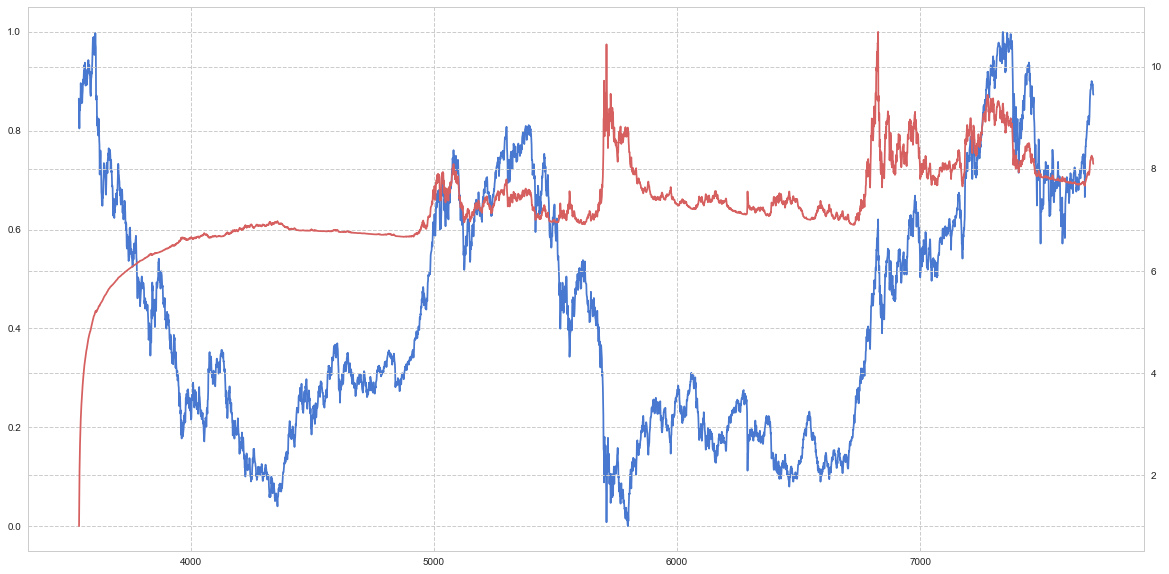

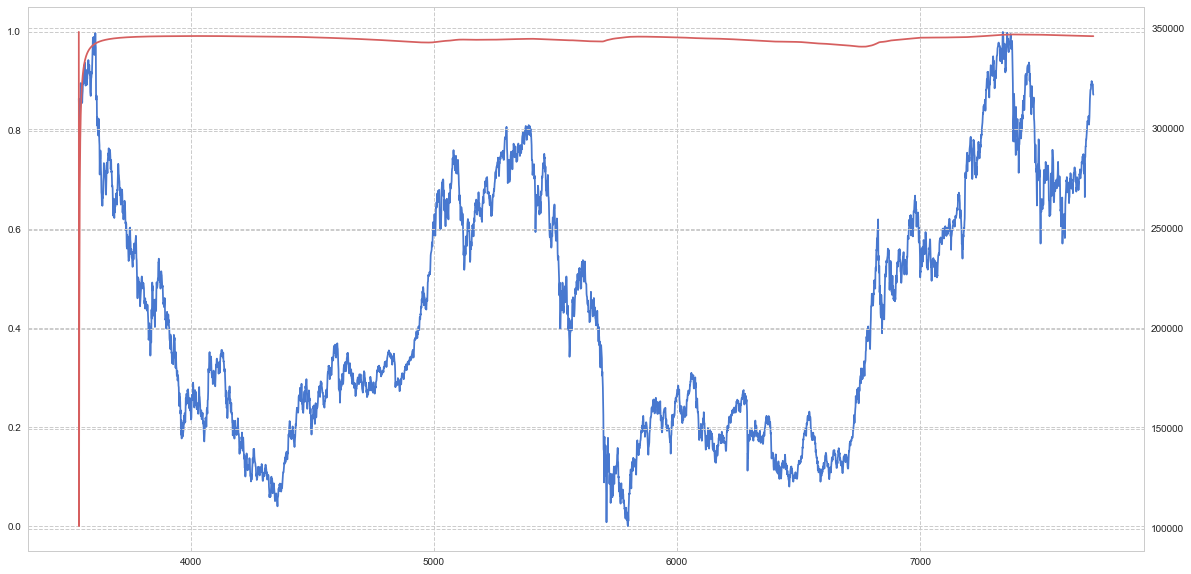

In [80]:
# data_uj: ret_n, data_n: ret_uj
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(df.Close)
ax2 = ax.twinx()
ax2.plot(df.S_L,'r')
plt.show()

# data_uj: ret_n, data_n: ret_uj
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(df.Close)
ax2 = ax.twinx()
ax2.plot(df.S_H,'r')
plt.show()

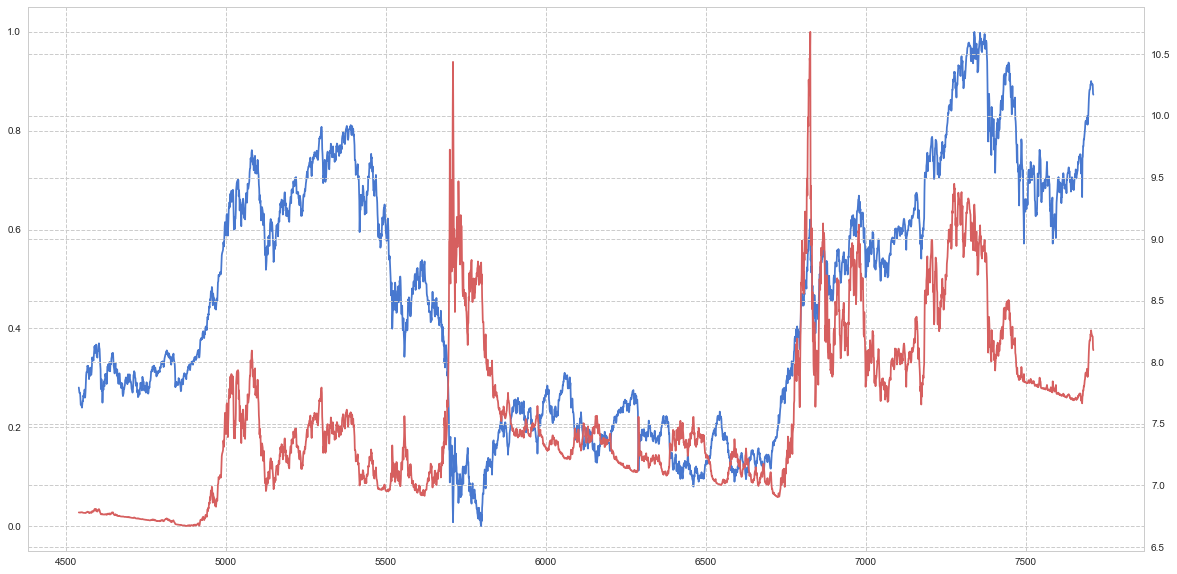

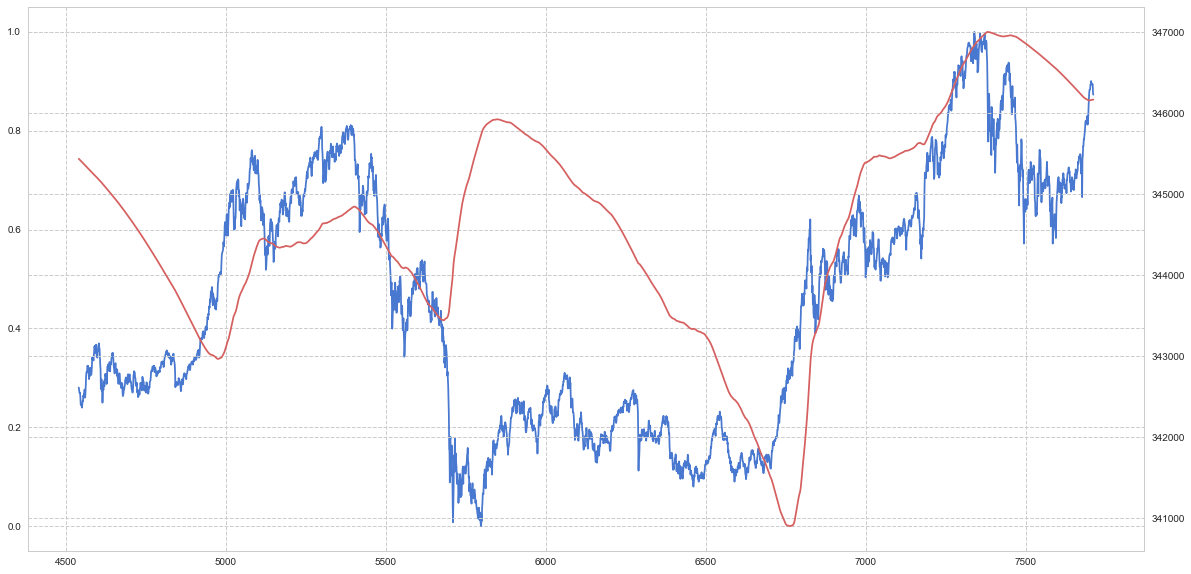

In [81]:
# data_uj: ret_n, data_n: ret_uj
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(df_tmp.Close)
ax2 = ax.twinx()
ax2.plot(df_tmp.S_L,'r')
plt.show()

# data_uj: ret_n, data_n: ret_uj
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(df_tmp.Close)
ax2 = ax.twinx()
ax2.plot(df_tmp.S_H,'r')
plt.show()